In [1]:
%load_ext autoreload

### Imports

In [10]:
%autoreload 2

from dataset import AudioDataSet
from graph_creator import draw_accuracy_train_valid, draw_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import librosa 
from torch import Tensor


### Load data 

In [3]:
n_mfcc=32
bins = 32
batch_size=16
labels_len = 12
hidden_dim = 256

torch.Size([16, 32, 32])


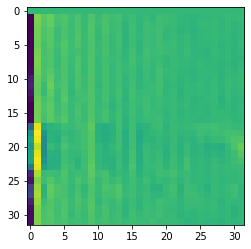

In [4]:
transform = transforms.Compose([
    lambda x: x.astype(np.float32) / (np.max(x) if np.max(x) != 0 else 1), # rescale to -1 to 1
    lambda x: librosa.feature.mfcc(x, sr=16000, n_mfcc=n_mfcc), # MFCC
    lambda x: [[*[0]*(max(0, bins-len(data))), *data[:bins]] for data in x],
    lambda x: Tensor(x),
    lambda x: x.transpose(0, 1)
])

dataloader = DataLoader(
    AudioDataSet(transform = transform, mode="train"),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

dataloader_valid = DataLoader(
    AudioDataSet(transform = transform, mode="validate"),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

for index, (data, label) in enumerate(dataloader):
    print(data.shape)
    plt.imshow(data.numpy()[0, :, :])
    plt.show()

    if index == 0:
        break

### Define model 

In [5]:
class LSTMTagger(nn.Module):

    def __init__(self, n_mfcc, bins, hidden_dim, tagset_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.tagset_size = tagset_size
        self.n_mfcc = n_mfcc
        self.filters = [32, 64]
        self.bins = bins
        self.pool_size = int(self.bins / 4)

        self.begFilter = nn.Sequential(
            nn.Conv2d(1, self.filters[0], 3, padding = 1),
            nn.BatchNorm2d(self.filters[0]),
            nn.ReLU(),
            nn.Conv2d(self.filters[0], self.filters[0], 3, padding = 1),
            nn.BatchNorm2d(self.filters[0]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p = 0.2)
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(self.filters[0], self.filters[1], 3, padding = 1),
            nn.BatchNorm2d(self.filters[1]),
            nn.ReLU(),
            nn.Conv2d(self.filters[1], self.filters[1], 3, padding = 1),
            nn.BatchNorm2d(self.filters[1]),
            nn.ReLU(),
            nn.Dropout2d(p = 0.2)
        )
        
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pool_size),
            nn.Dropout2d(p = 0.3)
        )
        
        self.lstm = nn.LSTM(self.pool_size * self.filters[1], hidden_dim, batch_first=True, num_layers=2)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sound):
        x = sound.view(len(sound), 1, self.bins, self.n_mfcc)
        x = self.begFilter(x)
        x = self.block1(x)
        x = self.pool(x)
        x = x.view(len(sound), self.pool_size, self.filters[1] * self.pool_size)
        lstm_out, _ = self.lstm(x)
        tag_space = self.hidden2tag(lstm_out[:,-1,:])
        return tag_space

In [6]:
def get_accuracy(net, valid_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for (images, labels) in valid_loader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            torch.cuda.empty_cache()
    return 100 * correct / total

###  Train model

In [8]:
model = LSTMTagger(n_mfcc, bins, hidden_dim, labels_len)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
losses = []
accuracies = []
for epoch in range(10):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels)  in enumerate(dataloader, 0):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        optimizer.zero_grad()
        if (i % 500 == 0 and i > 0):
            print(i)
        # Step 3. Run our forward pass.
        tag_scores = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    accuracies.append(get_accuracy(model, dataloader_valid))
    losses.append(running_loss / len(dataloader))

500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000


### Plot train info 

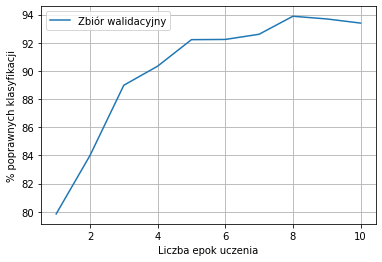

In [11]:
draw_accuracy_train_valid(accuracies)

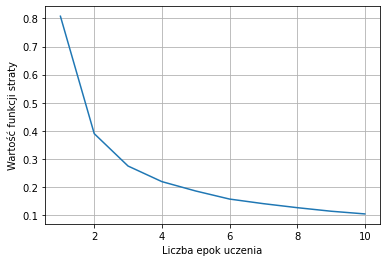

In [12]:
draw_loss(losses)

### Prepare data for kaggle 

In [13]:
transform = transforms.Compose([
    lambda x: x.astype(np.float32) / (np.max(x) if np.max(x) != 0 else 1), # rescale to -1 to 1
    lambda x: librosa.feature.mfcc(x, sr=16000, n_mfcc=n_mfcc), # MFCC
    lambda x: [[*[0]*(max(0, bins-len(data))), *data[:bins]] for data in x],
    lambda x: Tensor(x),
    lambda x: x.transpose(0, 1)
])

dataLoader_test = DataLoader(
    AudioDataSet(transform = transform, mode="test"),
    batch_size=1024,
    shuffle=False,
    num_workers=0
)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
def get_testLabels(net, test_loader, device):
    outputsLabels = np.array([])
    i = 0
    with torch.no_grad():
        for data in test_loader:
            i+=1
            images = data.to(device)
            outputs = net(images)
            if i % 20 == 0:
                print(i)
            _, predicted = torch.max(outputs.data, 1)
            outputsLabels = np.concatenate((outputsLabels, predicted.data.cpu().numpy()))
    return outputsLabels

outputLabelsss = get_testLabels(model, dataLoader_test, device)

20
40
60
80
100
120
140


In [15]:
import csv
import pandas as pd
def save(outputLabels):
    allLabels = list(AudioDataSet(transform = transform, mode="test").labels_dict.keys())
    knownLabels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"," unknown"]

    with open("../data/output.csv", 'w',newline="") as myfile:
        df = pd.read_csv("../data/test/test_list.csv")
        fields = ['fname', 'label']
        wr = csv.DictWriter(myfile,fieldnames=fields)
        wr.writeheader()
        for i, label in enumerate(outputLabels):
            outputLabel = allLabels[int(label)]
            if outputLabel not in knownLabels:
                outputLabel = "unknown"
            wr.writerow({"fname": df['path'][i], "label": outputLabel})

save(outputLabelsss)